In [1]:
#from transformer import Transformer
import torch
import numpy as np
import math

In [2]:
import numpy as np

def preprocess_data(func):
    """
    A decorator for preprocessing data. It normalizes and scales the input data.
    """
    def wrapper(data):
        # Convert data to a numpy array for ease of manipulation
        data_array = np.array(data)
        
        # Normalize data to have mean = 0
        normalized_data = data_array - np.mean(data_array, axis=0)
        
        # Scale data to have std deviation = 1
        scaled_data = normalized_data / np.std(normalized_data, axis=0)
        
        # Call the original function with the preprocessed data
        return func(scaled_data)
    
    return wrapper

@preprocess_data
def train_model(data):
    """
    Simulate model training on preprocessed data.
    """
    print("Training model on preprocessed data:")
    print(data)

# Example data - list of lists (each inner list could represent a data point)
data = [
    [10, 200, 3000],
    [20, 180, 2900],
    [15, 210, 3100],
]

train_model(data)


Training model on preprocessed data:
[[-1.22474487  0.26726124  0.        ]
 [ 1.22474487 -1.33630621 -1.22474487]
 [ 0.          1.06904497  1.22474487]]


In [3]:
L, d_k, d_v = 4, 8, 8
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)

print("Q\n", q) # queue
print("K\n", k) # key
print("V\n", v) # value

Q
 [[ 3.49091629e-04 -2.36564313e-01  3.93158170e-02  4.83598993e-01
  -2.29602947e-01 -7.35765196e-01  1.07824883e+00  5.66690295e-01]
 [ 1.23051533e+00 -4.33139369e-01  1.18632675e-01 -6.35105072e-01
   7.27291883e-01  6.83922365e-01  1.04503623e+00 -4.42515101e-01]
 [ 4.92282258e-01  2.87076127e-02  1.67373830e+00  3.22394141e-01
  -3.24316367e-01 -1.02331742e+00  3.93354903e-01 -3.58839411e-01]
 [ 4.26648044e-02 -1.41740165e+00  1.44892517e+00  9.75861054e-01
  -1.70714505e+00  3.56247539e-01 -1.43150950e-01 -5.42089755e-01]]
K
 [[ 0.81576652  0.13905938 -0.04025353  1.2167816   0.61761556  0.34638913
   0.20713831  0.63918787]
 [-1.28025409 -1.94942609  0.69737744  1.21971493 -0.24545391 -0.81391399
  -1.0323937   1.31551563]
 [-0.25614235 -0.26647644 -0.11443513  0.51109189 -0.63809394 -0.20404782
   0.43742648  0.64823154]
 [ 0.53449474  1.55257826  1.20347173  0.19976405  0.31349574 -1.20578455
   1.2722732   0.18830745]]
V
 [[ 0.96138538  0.22132426 -0.23674417  0.29412005  0.

In [4]:
# self attention matrix will have every word look at every other word in the sentence
# 4 cross 4 matrix for example "My name is Ken" len(4)
np.matmul(q, k.T)

array([[ 0.74314083,  1.36550776,  1.44125445,  2.070557  ],
       [ 0.78572838, -3.81910946, -0.97129758,  0.6507037 ],
       [ 0.02783304,  0.90858764,  0.19469716,  3.95150388],
       [-0.34032137,  4.47294916,  1.3023323 , -1.48808756]])

In [5]:
q.var(), k.var(), np.matmul(q, k.T).var()
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var() #minimize skew

(0.6061670609807732, 0.6805783024159235, 0.4522523984219733)

In [6]:
scaled

array([[ 0.26273996,  0.4827799 ,  0.5095604 ,  0.73205245],
       [ 0.27779693, -1.3502591 , -0.34340555,  0.2300585 ],
       [ 0.00984046,  0.32123424,  0.06883584,  1.3970676 ],
       [-0.12032177,  1.58142634,  0.460444  , -0.5261184 ]])

## Masking ##
- This is to ensure words don't get context from words generated in the future
- Not required in the encoders, but required in the decoders

In [7]:
mask = np.tril(np.ones( (L, L) )) # triangular matrix
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [8]:
mask[mask==0] = -np.infty
mask[mask==1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [9]:
scaled + mask

array([[ 0.26273996,        -inf,        -inf,        -inf],
       [ 0.27779693, -1.3502591 ,        -inf,        -inf],
       [ 0.00984046,  0.32123424,  0.06883584,        -inf],
       [-0.12032177,  1.58142634,  0.460444  , -0.5261184 ]])

In [10]:
# softmask, convert a vector into a probability distribution
def softmax(x): 
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T
attention = softmax(scaled + mask)

In [11]:
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.83590316, 0.16409684, 0.        , 0.        ],
       [0.29187731, 0.3985079 , 0.30961479, 0.        ],
       [0.11188965, 0.61354967, 0.1999923 , 0.07456837]])

In [12]:
new_v = np.matmul(attention, v)
new_v
# this new matricies better encapsulates the context of the masked words

array([[ 0.96138538,  0.22132426, -0.23674417,  0.29412005,  0.49256353,
        -0.6933207 , -1.83949971,  0.58269026],
       [ 0.87974592,  0.27558013, -0.13358034,  0.16255466,  0.27883251,
        -0.50612343, -1.40380444,  0.36205897],
       [ 0.79600866,  0.53947092,  0.07116715, -0.02549685, -0.02260406,
        -0.51230443,  0.24372959,  0.23434001],
       [ 0.51597246,  0.64515786,  0.15080117, -0.18831373, -0.21514052,
        -0.17118111,  0.46482014, -0.27190926]])

In [13]:
# MASK is set to true when we are decoding
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.shape[-1]
    scaled = np.matmul(q, k.T) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask
    attention = softmax(scaled)
    out = np.matmul(attention, v) # vector
    return out, attention

"""print("Q\n", q) # queue
print("K\n", k) # key
print("V\n", v) # value"""
#apply scaled product def
values, attnetion = scaled_dot_product_attention(q, k, v, mask=None)
print("New V\n", values)
print("Attention\n", attention)

New V
 [[ 0.19163855  0.87287014 -0.18504568  0.1390592   0.55102905 -0.64106133
  -0.31220246 -0.22374355]
 [ 0.17825615  0.84443695 -0.32144608  0.2809344   0.82301804 -0.79170901
  -0.92112393 -0.11179227]
 [-0.28130066  1.09487197 -0.34943714  0.21578155  0.89760055 -0.61749764
  -0.7842327  -0.66736491]
 [ 0.51597246  0.64515786  0.15080117 -0.18831373 -0.21514052 -0.17118111
   0.46482014 -0.27190926]]
Attention
 [[1.         0.         0.         0.        ]
 [0.83590316 0.16409684 0.         0.        ]
 [0.29187731 0.3985079  0.30961479 0.        ]
 [0.11188965 0.61354967 0.1999923  0.07456837]]


In [14]:
import torch 
import torch.nn as nn  
import torch.nn.functional as F

In [15]:
sequence_length = 4 # my name is ken
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [16]:
x.size()
qkv_layer = nn.Linear(input_dim, 3 * d_model)
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

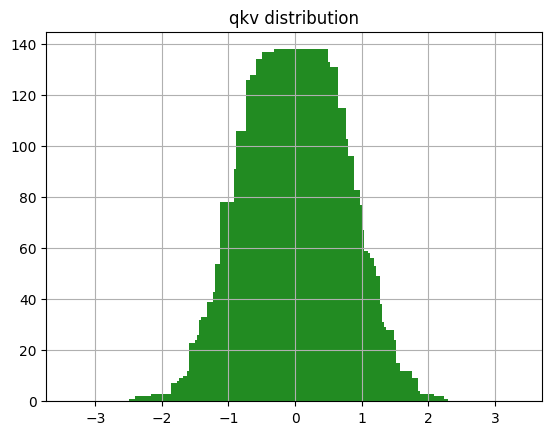

In [17]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align="center", color=["forestgreen"])
plt.title("qkv distribution")
plt.grid(True)

Sampling from a random normal distribution. 

In [18]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape

qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [19]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [20]:
d_k = q.size()[-1]
# -2 == last two attrs/dimensions
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [21]:
k.T.shape
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

/var/folders/g4/ykwfgyl55t7dfzv_zc3dcshh0000gn/T/ipykernel_1292/4066560417.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  k.T.shape


tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [22]:
(scaled + mask)[0][0]

tensor([[-0.2979,    -inf,    -inf,    -inf],
        [ 0.0806, -0.0394,    -inf,    -inf],
        [ 0.4009, -0.0070,  0.4119,    -inf],
        [-0.4489, -0.1323,  0.0221, -0.0980]], grad_fn=<SelectBackward0>)

In [23]:
scaled += mask

In [24]:
attention = F.softmax(scaled, dim=-1)
attention.shape
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5300, 0.4700, 0.0000, 0.0000],
        [0.3737, 0.2485, 0.3778, 0.0000],
        [0.1854, 0.2544, 0.2969, 0.2633]], grad_fn=<SelectBackward0>)

In [25]:
values = torch.matmul(attention, v)
values.shape #much more context aware

torch.Size([1, 8, 4, 64])

In [26]:
# updated function
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2) / math.sqrt(d_k))
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [27]:
values, attention = scaled_dot_product(q, k, v, mask=None)

In [29]:
attention.shape, values.shape

(torch.Size([1, 8, 4, 4]), torch.Size([1, 8, 4, 64]))

In [30]:
attention[0][0]

tensor([[0.2350, 0.2686, 0.1471, 0.3492],
        [0.2718, 0.2411, 0.1734, 0.3137],
        [0.2936, 0.1952, 0.2968, 0.2144],
        [0.1854, 0.2544, 0.2969, 0.2633]], grad_fn=<SelectBackward0>)

In [31]:
values.size()

torch.Size([1, 8, 4, 64])

In [32]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [33]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape, out

(torch.Size([1, 4, 512]),
 tensor([[[ 0.1173, -0.1710,  0.0064,  ..., -0.1207,  0.3013,  0.1639],
          [ 0.0469,  0.0930,  0.0426,  ..., -0.2752, -0.1506,  0.0289],
          [ 0.1419, -0.0419, -0.0672,  ..., -0.1362,  0.0857,  0.1898],
          [ 0.0183,  0.0776, -0.0284,  ..., -0.2607,  0.1579, -0.0055]]],
        grad_fn=<ViewBackward0>))

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"value.size(): {values.size()}, attention.size(): {attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out # eof

In [38]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim))

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64])
value.size(): torch.Size([30, 8, 5, 64]), attention.size(): torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
